In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
from dataset import Dataset, to_device
from model import NNSingleFeatureModel, tims_mse_loss, tim95_mse_loss
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pickle
import normalize_data
import random
from time import time
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', 999)
pd.set_option('display.precision', 12)

In [2]:
raw_data = {} # loads raw data and stores as a dict cache

def dataset_key(dataset='', validation=False):
    return dataset+('test' if validation else 'train')

def load_data(raw, dataset='', validation=False):
    key = dataset+('test' if validation else 'train')
    if key not in raw:
        print(f"Loading data to cache for: {key}")
        raw[key] = pd.read_pickle(f'{os.environ["GP_HIST_PATH"]}/../t7_data/{key}.pkl')
    return raw[key]

In [3]:
def load_sub_model_with_config(train_config, model_configs, sub_model_key, X_count=0, force_recreate=False):
    path = train_config['model_path']
    prefix = train_config['model_prefix']
    model_config = model_configs[sub_model_key]
    f = f"{path}/{prefix}{sub_model_key}.pth"
    if os.path.exists(f) and not force_recreate:
        print("Loading existing model")
        checkpoint = torch.load(f)
        net = checkpoint['net']
        loss_func = checkpoint['loss_func']
        optimizer = checkpoint['optimizer']
        mean_losses = checkpoint['mean_losses']
        next_epoch = checkpoint['next_epoch']
    else:
        raise Exception('Model does not exist')
    return net, loss_func, optimizer, mean_losses, next_epoch

In [4]:
# # incase i need to save the current model in memory
# def save_model_with_config(train_config, sub_model_key, **kwargs):
#     path = train_config['model_path']
#     prefix = train_config['model_prefix']
#     f = f"{path}/{prefix}{sub_model_key}.pth"
#     torch.save(kwargs, f)

In [5]:
def predict(model, X, y, device='cpu'):
    pyt_device = torch.device(device)
    model.eval()
    X_tensor = torch.from_numpy(X.to_numpy()).float()
    nn_results = model(X_tensor).detach().numpy()
    return nn_results

In [6]:
def get_ref_X_y(df):
    ref_cols = [c for c in df.columns if c.startswith('__')]
    X_cols = [c for c in df.columns if c.startswith('X_')]
    y_cols = [c for c in df.columns if c.startswith('y_')]
    return (df[ref_cols], df[X_cols], df[y_cols])

In [7]:
train_config = {
    'dataset' : 'sample_200_', # '', 'sample_', 'secret_'
    'model_prefix' : "SINGLE_0_", 
    'model_path' : f"{os.environ['GP_HIST_PATH']}/../t7_models",
    'device' : 'cpu',
}

In [8]:
%%time
test_df = normalize_data.normalize_all_columns(load_data(raw_data,dataset=train_config['dataset'],validation=True)).dropna()
ref_test, X_test, y_test = get_ref_X_y(test_df)
# y_cols = ['y_INCLINATION', 'y_ECCENTRICITY', 'y_MEAN_MOTION', 'y_RA_OF_ASC_NODE_REG', 'y_ARG_OF_PERICENTER_REG', 'y_REV_MA_REG', 'y_BSTAR']
# y_test = y_test[y_cols]

Loading data to cache for: sample_200_test
CPU times: user 676 ms, sys: 639 ms, total: 1.31 s
Wall time: 897 ms


In [9]:
model_configs = {
    'y_SAT_RX': { 
    },
    'y_SAT_RY': { 
    },
    'y_SAT_RZ': { 
    },
    'y_SAT_VX': { 
    },
    'y_SAT_VY': { 
    },
    'y_SAT_VZ': { 
    },
}

Loading existing model
y_SAT_RX
MSELoss()


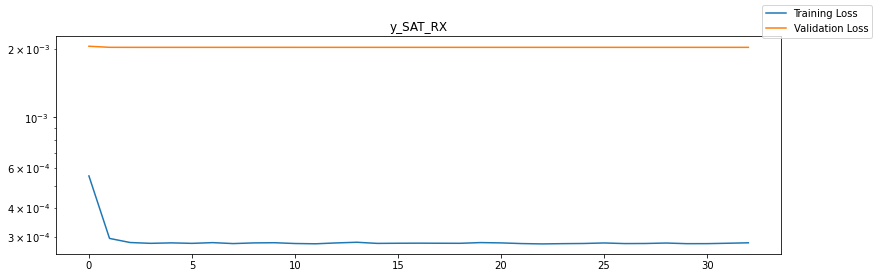

,train loss,validation loss
23,0.000279409908,0.002031233576
24,0.000279882111,0.002031182030
25,0.000281370979,0.002031194044
26,0.000279616211,0.002031152567
27,0.000279861546,0.002031185714
28,0.000281179701,0.002031198233
29,0.000279369084,0.002031180037
30,0.000279445313,0.002031166423
31,0.000280564320,0.002031165124
32,0.000281835227,0.002031185861


Epoch 33
    Test set MAE (L1) loss: 0.002799321021077943
    Test set MSE (L2) loss: 0.0017543101868913048
Loading existing model
No data for y_SAT_RY
Loading existing model
No data for y_SAT_RZ
Loading existing model
No data for y_SAT_VX
Loading existing model
No data for y_SAT_VY
Loading existing model
No data for y_SAT_VZ


,y_SAT_RX,y_SAT_RX_pred
0,-0.278770563185,-0.278621733189
1,-0.175395993702,-0.175052791834
2,-0.125969005786,-0.126286774874
3,-0.094794682753,-0.094790205359
4,-0.013679499544,-0.013781782240
...,...,...
479660,-0.753290479244,-0.413678228855
479661,-0.742980631570,-0.461483359337
479662,-0.719214177844,-0.089906089008
479663,-0.701667344477,0.069660402834


In [12]:
# Create or load all new sub models here if needed.
# sample_idx = random.sample(list(X_test.index), 10000)
sample_idx = X_test.index
all_models = {}
display_data = []
# for sub_key in y_cols:
for sub_key in model_configs.keys():
    # When new models are created, a dummy optimizer is used
    model, loss_func, optimizer, mean_losses, next_epoch = load_sub_model_with_config(train_config, model_configs, sub_key)
    all_models[sub_key] = (model, loss_func, optimizer, mean_losses, next_epoch)
    try:
        tl, vl = zip(*mean_losses)
        print(f'{sub_key}')
    except:
        print(f"No data for {sub_key}")
        continue

    fig,ax = plt.subplots(figsize=(13,4))
    print(loss_func)
    ax.plot(tl, label="Training Loss")
    ax.plot(vl, label="Validation Loss")
    ax.set_title(sub_key)
    ax.set_yscale('log')
    ax.set_ylim((ax.get_ylim()[0], min(1,ax.get_ylim()[1])))
    fig.legend()
    plt.show()
    display(pd.DataFrame(mean_losses, columns=['train loss','validation loss']).tail(10))

    trained_model = model
    X_sample = X_test.loc[sample_idx]
    y_sample = y_test.loc[sample_idx][[sub_key]]
    y_sample_pred = predict(trained_model, X_sample, y_sample, device="cpu") # get predictions for each train
    y_sample_pred_df = pd.DataFrame(y_sample_pred, columns=y_sample.columns, index=y_sample.index)  # put results into a dataframe
    print(f'Epoch {next_epoch}')
    print(f'    Test set MAE (L1) loss: {mean_absolute_error(y_sample, y_sample_pred_df)}')
    print(f'    Test set MSE (L2) loss: {mean_squared_error(y_sample, y_sample_pred_df)}')
    display_data.append(y_sample)
    display_data.append(y_sample_pred_df.add_suffix('_pred'))
#     display_data.append(X_sample.iloc[:,model_configs[sub_key]['feature_index']:model_configs[sub_key]['feature_index']+1])
#     display(X_sample.iloc[:,model_configs[sub_key]['feature_index']:model_configs[sub_key]['feature_index']+1].values - y_sample_pred_df.values)
    print('==============================')
df = pd.concat(display_data, axis=1)
display(df)
# df['error'] = (np.abs(df.iloc[:,0]*360 - df.iloc[:,1]*360))%360
# df['error'] = np.minimum(360-df.error,df.error)
# display(df.error.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.975, 0.99, 0.999]))
# df['epoch_diff'] = X_sample.X_delta_EPOCH
# display(df.error.describe())

In [ ]:
df = df.sort_values('error', ascending=False)
df = df.merge(ref_test, left_index=True, right_index=True)

In [ ]:
df